In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random
import cv2
import Comparison_v2
import os
from DataSetting_v2 import DataPlanner as DP

In [22]:
from misc import plot_settings
class ResultCalculator:
    zero = False

    def __init__(self, name, pred_path, gt=None):
        self.name = name
        print(f"{self.name} loading...")
        self.preds: dict = np.load(pred_path, allow_pickle=True).item() if pred_path else None
        self.tags = self.preds['TAG'] if pred_path else None
        if self.preds:
            print("{name} loaded Estimates of {pred_img.shape} as {pred_img.dtype}".format(
                name=self.name,
                pred_img=np.array(self.preds['S_PRED'] if 'S_PRED' in self.preds.keys() else self.preds['PRED']))
            )

        self.gt = gt
        self.gt_ind = gt['ind']
        self.image_size = (128, 226)  # in rows * columns
        self.resized = np.zeros((len(self.tags), *self.image_size)) if pred_path else None
        self.result = np.zeros_like(self.tags) if pred_path else None
        self.loss = F.mse_loss

    def resize(self):
        print(f"{self.name} resizing...", end='')
        for i in range(len(self.tags)):
            self.resized[i] = cv2.resize(
                np.squeeze(self.preds['S_PRED'][i] if 'S_PRED' in self.preds.keys() else self.preds['PRED'][i]),
                (self.image_size[1], self.image_size[0]))
        print("Done!")

    def calculate_loss(self):
        print(f"{self.name} calculating loss...", end='')
        for i, tag in enumerate(self.tags):
            # Locate ground truth by ind and take
            take, ind = tag[0], tag[-1]
            _ind = np.where(self.gt['tag'][:, -1] == ind)
            _take = np.where(self.gt['tag'][_ind][:, 0] == take)

            pred = torch.from_numpy(self.resized[i])
            self.result[i] = F.mse_loss(pred, torch.from_numpy(self.gt['tag'][_ind][_take]))
        print("Done")
        if np.any(np.isnan(self.result)):
            print("nan detected!")

    def calculate_cdf(self):
        print(f"{self.name} calculating histograms...", end='')
        hist, bin_edges = np.histogram(self.result)
        print("Done!")
        fig = plot_settings()
        fig.suptitle(f"{self.name} Loss on Raw Images")
        width = (bin_edges[1] - bin_edges[0]) * 0.8
        cdf = np.cumsum(hist / sum(hist))

        plt.bar(bin_edges[1:], hist / max(hist), width=width, alpha=0.5)
        plt.plot(bin_edges[1:], cdf, '-*')

        plt.ylim([0, 1])
        plt.title('Test PDF-CDF', fontweight="bold")
        plt.xlabel('Per-sample Loss')
        plt.ylabel('Frequency')
        plt.grid()
        plt.legend()
        plt.show()
        filename = f"{self.name}_CDF.jpg"
        return fig, filename
    
    
class BBXResultCalculator(ResultCalculator):
    def __init__(self, *args, **kwargs):
        super(BBXResultCalculator, self).__init__(*args, **kwargs)

        self.bbx = np.array(self.preds['S_BBX'])
        self.depth = np.array(self.preds['S_DPT'])

        self.min_area = 0
        self.fail_count = 0
        self.fail_ind = []

    def resize(self):
        print("Reconstructing...", end='')
        for i in range(len(self.inds)):
            img = np.squeeze(self.preds['S_PRED'][i]) * np.squeeze(self.depth[i])
            (T, timg) = cv2.threshold((img * 255).astype(np.uint8), 1, 255, cv2.THRESH_BINARY)
            contours, hierarchy = cv2.findContours(timg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) != 0:
                contour = max(contours, key=lambda x: cv2.contourArea(x))
                area = cv2.contourArea(contour)

                if area < self.min_area:
                    # print(area)
                    pass

                else:
                    x, y, w, h = cv2.boundingRect(contour)
                    subject = img[y:y + h, x:x + w]

                    x1, y1, x2, y2 = self.bbx[i]
                    x0 = int(x1 * 226)
                    y0 = int(y1 * 128)
                    w0 = int((x2 - x1) * 226)
                    h0 = int((y2 - y1) * 128)

                    # In case of reversing (x1, y1) and (x2, y2)
                    if w0 < 0 and h0 < 0:
                        x0 = int(x2 * 226)
                        y0 = int(y2 * 128)
                        w0 = int((x1 - x2) * 226)
                        h0 = int((y1 - y2) * 128)

                    try:
                        subject1 = cv2.resize(subject, (w0, h0))
                        for x_ in range(w0):
                            for y_ in range(h0):
                                self.resized[i, y0 + y_, x0 + x_] = subject1[y_, x_]
                    except Exception as e:
                        print(e)
                        print(x0, y0,  w0, h0)
                        self.fail_count += 1
                        self.fail_ind.append(i)
        print("Done")
        print(f"Reconstruction finished. Failure count = {self.fail_count}")

    def plot_example(self, inds=None, title=None):
        fig = plot_settings()
        fig.suptitle(f"{self.name} Reconstruction Examples" if not title else title)

        subfigs = fig.subfigures(nrows=4, ncols=1)

        plot_terms = {'Cropped Ground Truth': self.preds['GT'],
                      'Cropped Estimates': self.preds['S_PRED'],
                      'Raw Ground Truth': self.gt,
                      'Raw Estimates': self.resized}

        if not inds:
            inds = np.random.choice(np.arange(len(self.preds['IND'])), 8, replace=False).astype(int)
            inds = np.sort(inds)
        samples = np.array(self.preds['IND']).astype(int)[inds]

        for i, (key, value) in enumerate(plot_terms.items()):
            subfigs[i].suptitle(key, fontweight="bold")
            axes = subfigs[i].subplots(nrows=1, ncols=8)
            for j in range(len(axes)):
                _ind = np.where(self.gt_ind == samples[j])
                img = axes[j].imshow(np.squeeze(value[_ind]) if key == 'Raw Ground Truth'
                                     else np.squeeze(value[inds[j]]), vmin=0, vmax=1)
                if key == 'Raw Ground Truth':
                    x1, y1, x2, y2 = self.preds['GT_BBX'][inds[j]]
                    x = int(x1 * 226)
                    y = int(y1 * 128)
                    w = int((x2 - x1) * 226)
                    h = int((y2 - y1) * 128)
                    axes[j].add_patch(Rectangle((x, y), w, h, edgecolor='pink', fill=False, lw=3))
                elif key == 'Raw Estimates':
                    x1, y1, x2, y2 = self.preds['S_BBX'][inds[j]]
                    x = int(x1 * 226)
                    y = int(y1 * 128)
                    w = int((x2 - x1) * 226)
                    h = int((y2 - y1) * 128)
                    axes[j].add_patch(Rectangle((x, y), w, h, edgecolor='orange', fill=False, lw=3))
                axes[j].axis('off')
                axes[j].set_title(f"#{samples[j]}")
        plt.show()
        filename = f"{self.name}_Reconstruct.jpg"
        return fig, filename


class CenterResultCalculator(ResultCalculator):
    def __init__(self, *args, **kwargs):
        super(CenterResultCalculator, self).__init__(*args, **kwargs)

        self.center = np.array(self.preds['S_CTR'])
        self.depth = np.array(self.preds['S_DPT'])

        self.fail_count = 0
        self.fail_ind = []

    def resize(self):
        print("Reconstructing...", end='')

        for i, (x, y) in enumerate(self.center):
            x = int(x * 226)
            y = int(y * 128)
            new_img = np.zeros((128 + np.abs(y-64), 226 + np.abs(x-113)))
            try:
                if x > 113:
                    if y > 64:
                        new_img[-128:, -128:] = self.preds['S_PRED'][i]
                        self.resized[i] = new_img[:128, :226]
                    else:
                        new_img[:128, -128:] = self.preds['S_PRED'][i]
                        self.resized[i] = new_img[-128:, :226]
                else:
                    if y > 64:
                        new_img[-128:, :128] = self.preds['S_PRED'][i]
                        self.resized[i] = new_img[:128, -226:]
                    else:
                        new_img[:128, :128] = self.preds['S_PRED'][i]
                        self.resized[i] = new_img[-128:, -226:]

            except Exception as e:
                print(e)
                print(x, y)
                self.fail_count += 1
                self.fail_ind.append(i)

        print("Done")
        print(f"Reconstruction finished. Failure count = {self.fail_count}")

    def plot_example(self, inds=None, title=None):
        fig = plot_settings()
        fig.suptitle(f"{self.name} Reconstruction Examples" if not title else title)

        subfigs = fig.subfigures(nrows=4, ncols=1)

        plot_terms = {'Cropped Ground Truth': self.preds['GT'],
                      'Cropped Estimates': self.preds['S_PRED'],
                      'Raw Ground Truth': self.gt,
                      'Raw Estimates': self.resized}

        if not inds:
            inds = np.random.choice(np.arange(len(self.preds['IND'])), 8, replace=False).astype(int)
            inds = np.sort(inds)
        samples = np.array(self.preds['IND']).astype(int)[inds]

        for i, (key, value) in enumerate(plot_terms.items()):
            subfigs[i].suptitle(key, fontweight="bold")
            axes = subfigs[i].subplots(nrows=1, ncols=8)
            for j in range(len(axes)):
                _ind = np.where(self.gt_ind == samples[j])
                img = axes[j].imshow(np.squeeze(value[_ind]) if key == 'Raw Ground Truth'
                                     else np.squeeze(value[inds[j]]), vmin=0, vmax=1)
                if key == 'Raw Ground Truth':
                    x1, y1 = self.preds['GT_CTR'][i]
                    x1 = int(x1 * 226)
                    y1 = int(y1 * 128)
                    axes[j].scatter(x1, y1, c='blue', marker=(5, 1), alpha=0.5, linewidths=5, label='GT_CTR')
                elif key == 'Raw Estimates':
                    x2, y2 = self.preds['S_CTR'][i]
                    x2 = int(x2 * 226)
                    y2 = int(y2 * 128)
                    axes[j].scatter(x2, y2, c='orange', marker=(5, 1), alpha=0.5, linewidths=5, label='S_CTR')
                axes[j].axis('off')
                axes[j].set_title(f"#{samples[j]}")
        plt.show()
        filename = f"{self.name}_Reconstruct.jpg"
        return fig, filename


class ZeroEstimates(ResultCalculator):
    zero = True

    def __init__(self, *args, **kwargs):
        super(ZeroEstimates, self).__init__(*args, **kwargs)

        self.inds = self.gt_ind
        print(f"{self.name} loaded Zero Estimates")

        self.resized = np.zeros((len(self.inds), *self.image_size))
        self.result = np.zeros_like(self.inds, dtype=float)

    def resize(self):
        print(f"{self.name} resized")


def gather_plot(*args: ResultCalculator, title=None):
    fig = plot_settings()
    fig.suptitle('Comparison Results' if not title else title)

    bins = np.linspace(np.min([np.min(ar.result) for ar in args]), np.max([np.max(ar.result) for ar in args]), 50)

    for i, ar in enumerate(args):

        hist_, bin_edges = np.histogram(ar.result, bins)
        width = (bin_edges[1] - bin_edges[0]) * 0.8
        cdf = np.cumsum(hist_ / sum(hist_))
        if not ar.zero:
            plt.bar(bin_edges[1:], hist_ / max(hist_), width=width, label=ar.name, zorder=i)
            plt.plot(bin_edges[1:], cdf, '-*', label=ar.name, zorder=i+len(args))
        else:
            plt.bar(bin_edges[1:], hist_ / max(hist_), width=width * 0.4, label=ar.name, hatch='-', zorder=len(args))
            plt.plot(bin_edges[1:], cdf, '-.', marker='o', label=ar.name, zorder=2*len(args))

    ax = plt.gca()
    ax.fill_between(np.arange(0, np.max([np.max(ar.result) for ar in args]), 0.01), 1.02,
                    color='white', alpha=0.5, zorder=len(args)+0.5)
    plt.title('Test PDF-CDF', fontweight="bold")
    plt.xlabel('Per-sample Loss')
    plt.ylabel('Frequency')
    plt.grid()
    plt.legend()
    plt.show()
    filename = f"comparison_CDF.jpg"

    return fig, filename


def visualization(*args: ResultCalculator, inds=None, figsize=(20, 10), title=None):
    fig = plot_settings(figsize)
    fig.suptitle('Comparison Visualization' if not title else title)

    if not inds:
        inds = np.random.choice(np.arange(len(args[0].preds['IND'])), 8, replace=False).astype(int)
        inds = np.sort(inds)
    samples = np.array(args[0].preds['IND']).astype(int)[inds]

    subfigs = fig.subfigures(nrows=len(args) + 1, ncols=1)

    subfigs[0].suptitle("Ground Truth", fontweight="bold")
    axes = subfigs[0].subplots(nrows=1, ncols=8)
    for j in range(len(axes)):
        _ind = np.where(args[0].gt_ind == samples[j])
        img = axes[j].imshow(np.squeeze(args[0].gt[_ind]), vmin=0, vmax=1)
        axes[j].axis('off')
        axes[j].set_title(f"#{samples[j]}")

    for i, ar in enumerate(args):
        if not ar.zero:
            subfigs[i+1].suptitle(ar.name, fontweight="bold")
            axes = subfigs[i+1].subplots(nrows=1, ncols=8)
            for j in range(len(axes)):
                _ind = np.where(ar.preds['IND'] == samples[j])
                img = axes[j].imshow(np.squeeze(ar.resized[_ind]), vmin=0, vmax=1)
                axes[j].axis('off')
                axes[j].set_title(f"#{samples[j]}")
    plt.show()
    filename = f"comparison_visual.jpg"
    return fig, filename


### Comparison

In [3]:
notion = '240513Comp1'
save_path = f'../saved/{notion}/'
figs = []

In [4]:
datadir = f'../dataset/0509/make19_30/'
dataplanner = DP(datadir)
dataplanner.load_raw(scope=('T03', 'T04'), mmap_mode='r')
test_data = dataplanner.regroup({'T03', 'T04'})

Loading dataset...


  0%|          | 0/1213 [00:00<?, ?it/s]

Regrouping...


  0%|          | 0/10 [00:00<?, ?it/s]

T04 tag len=21 
T03 tag len=57 
T04 depth len=21 
T03 depth len=57 
T04 csi len=21 
T03 csi len=57 
T04 center len=21 
T03 center len=57 
T04 pd len=21 
T03 pd len=57 
T04 cimg len=21 
T03 cimg len=57 
T04 bbx len=21 
T03 bbx len=57 
T04 time len=21 
T03 time len=57 
T04 ind len=21 
T03 ind len=57 
T04 rimg len=21 
T03 rimg len=57 


In [5]:
print(dataplanner.data.keys())

dict_keys([3, 4])


30Center loading...
30Center loaded Estimates of (5069, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


TypeError: unhashable type: 'numpy.ndarray'

<Figure size 1440x720 with 0 Axes>

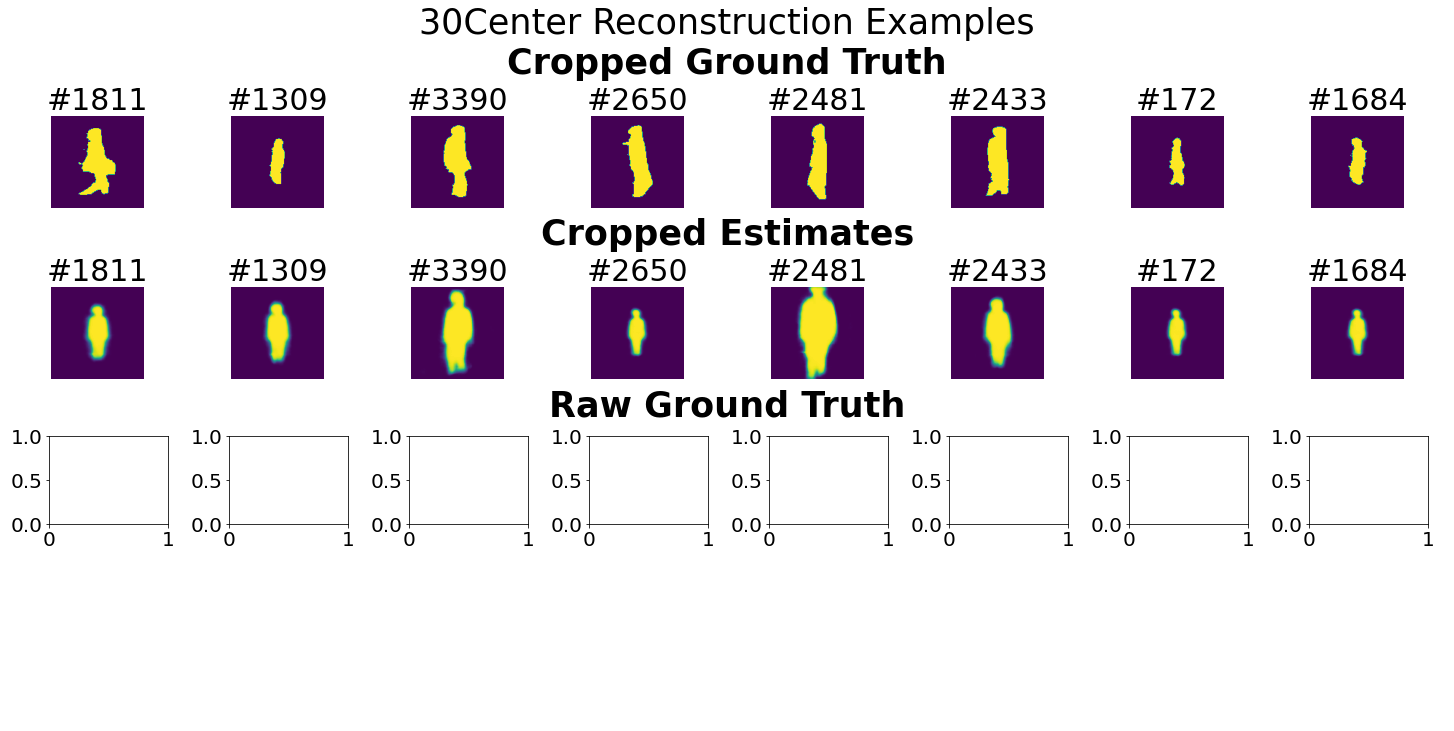

In [23]:
C30 = CenterResultCalculator('30Center', '../saved/240512_30C/240512_30C_Student_pred.npy', test_data)
C30.resize()
figs.append(C30.plot_example())

30Few loading...
30Few loaded Estimates of (8768, 128, 128) as float32
Reconstructing...OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

156 84 0 -47
Done
Reconstruction finished. Failure count = 1


<Figure size 1440x720 with 0 Axes>

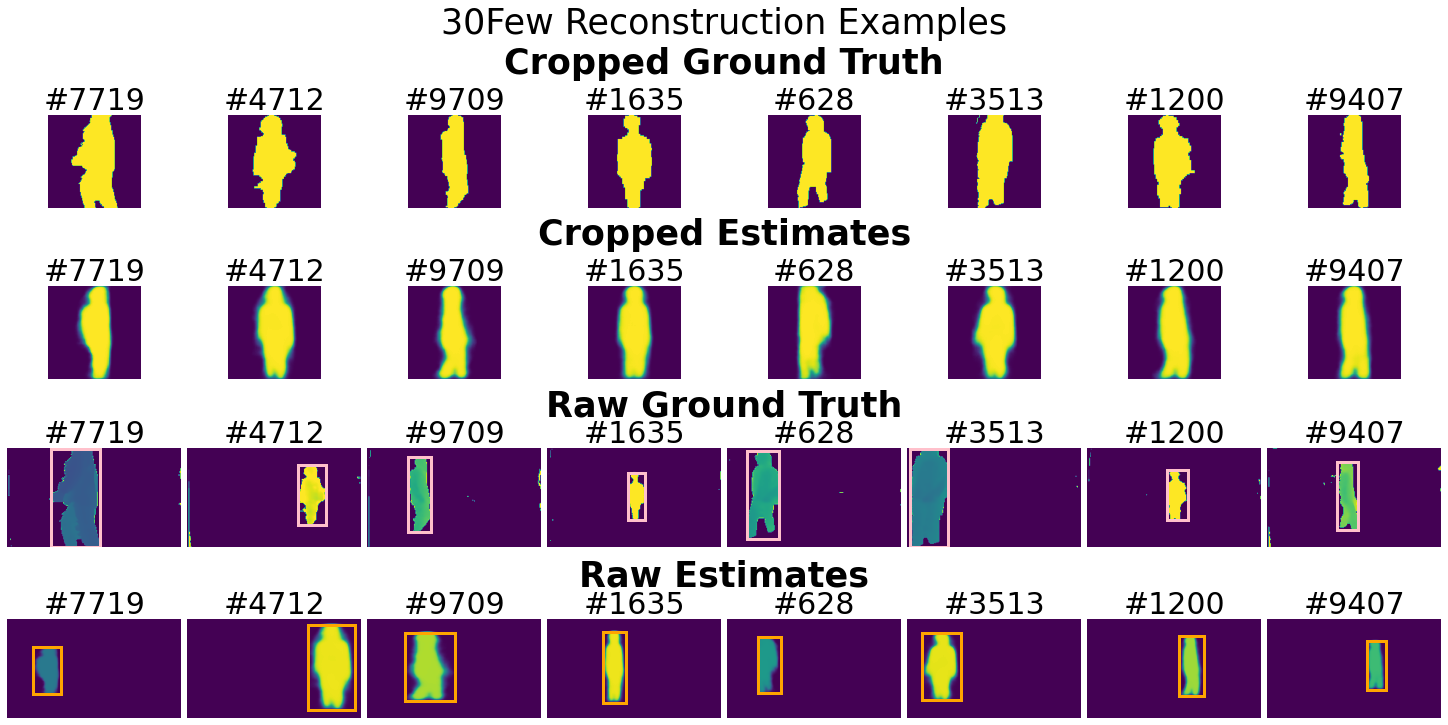

In [10]:
F30_gt = np.squeeze(np.load('../dataset/0509/make14-split-few/rimg_test.npy', mmap_mode='r'))
F30_gt_ind = np.load('../dataset/0509/make14-split-few/ind_test.npy', mmap_mode='r')

F30 = Comparison.PropResultCalculator('30Few', '../saved/240331R1Prop/240331R1Prop_Student_pred.npy', F30_gt, F30_gt_ind)
F30.resize()
figs.append(F30.plot_example())

100Normal loading...
100Normal loaded Estimates of (342, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 432x288 with 0 Axes>

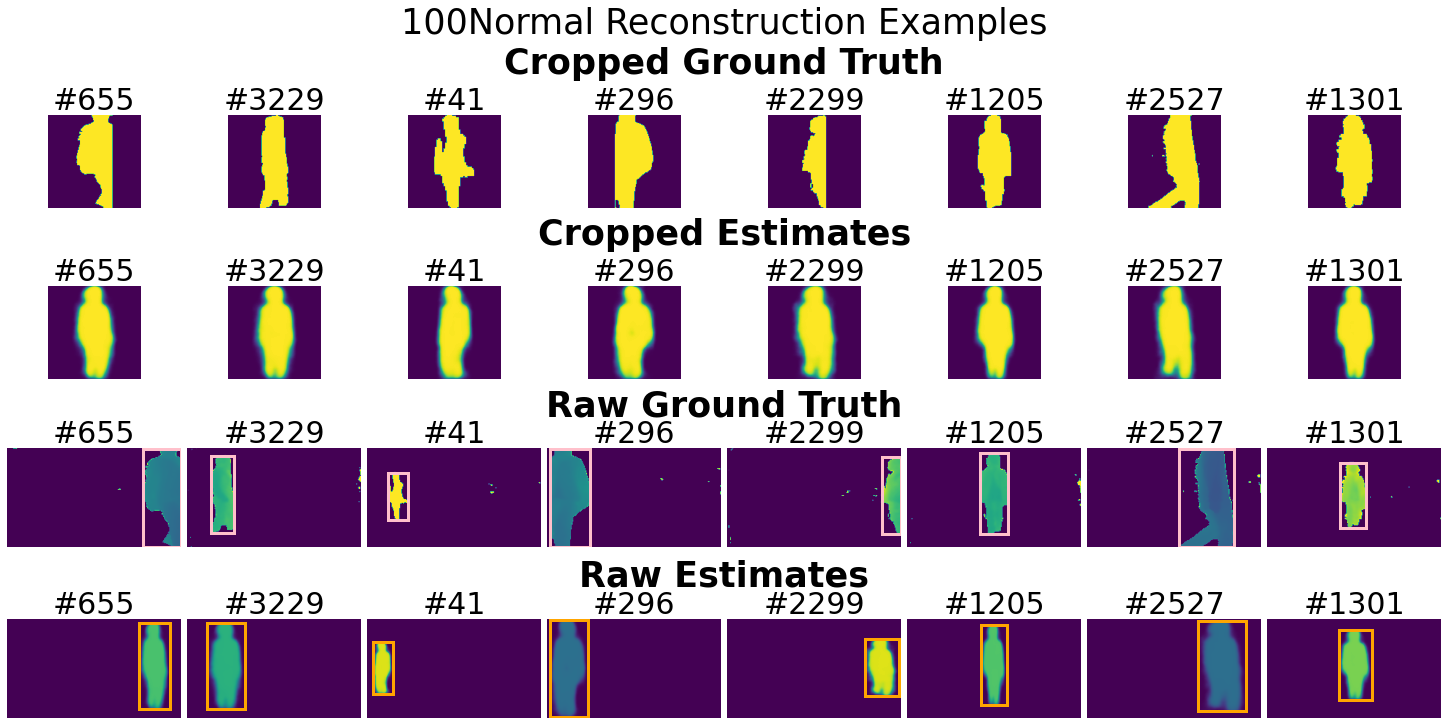

In [3]:
N100_gt = np.squeeze(np.load('../dataset/0509/make16_100-split/r_img_test.npy', mmap_mode='r'))
N100_gt_ind = np.load('../dataset/0509/make16_100-split/ind_test.npy', mmap_mode='r')

N100 = Comparison.PropResultCalculator('100Normal', '../saved/240414R1/240414R1_Student_pred.npy', N100_gt, N100_gt_ind)
N100.resize()
figs.append(N100.plot_example())

100Few loading...
100Few loaded Estimates of (2732, 128, 128) as float32
Reconstructing...OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

41 70 0 -16
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

25 77 0 -28
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

140 74 3 -27
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

43 72 0 -22
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

99 74 0 -22
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

28 74 0 -21
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize

<Figure size 1440x720 with 0 Axes>

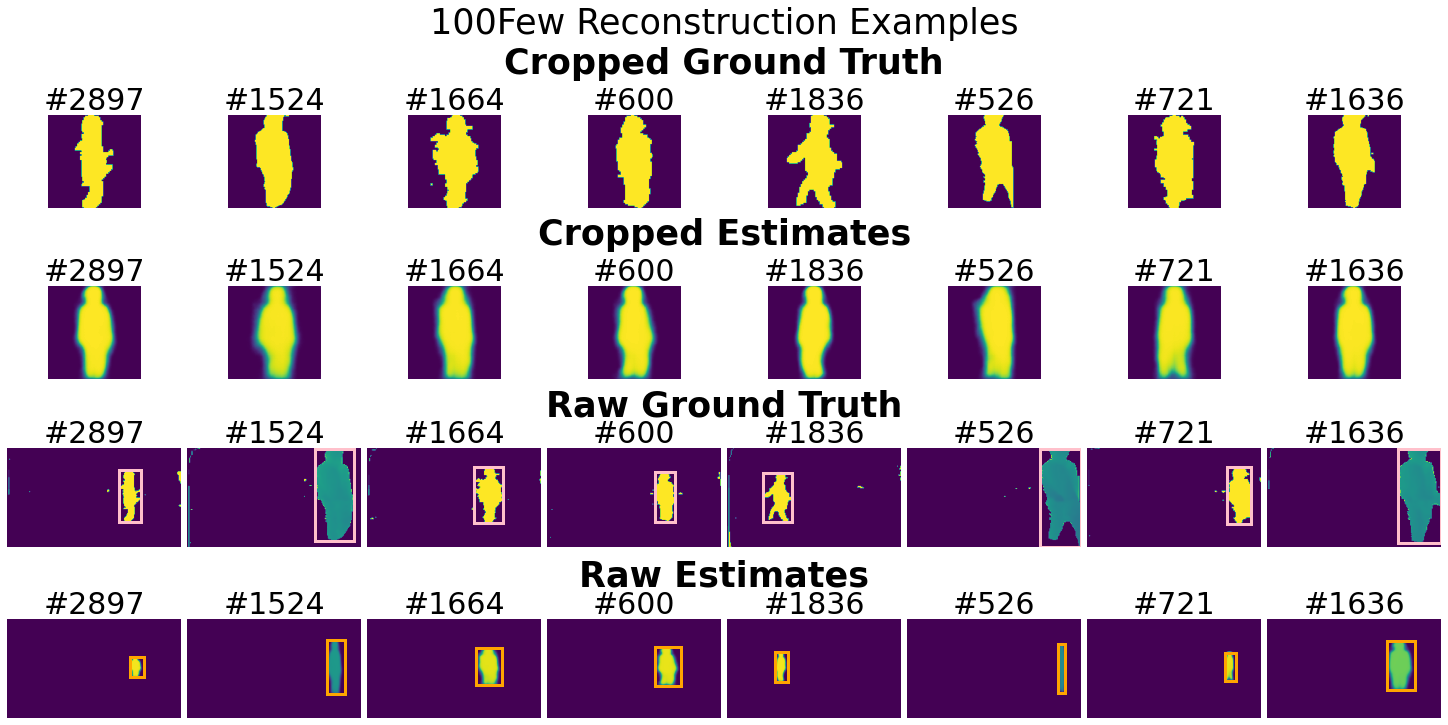

In [4]:
F100_gt = np.squeeze(np.load('../dataset/0509/make16_100-few/r_img_test.npy', mmap_mode='r'))
F100_gt_ind = np.load('../dataset/0509/make16_100-few/ind_test.npy', mmap_mode='r')

F100 = Comparison.PropResultCalculator('100Few', '../saved/240414R2/240414R2_Student_pred.npy', F100_gt, F100_gt_ind)
F100.resize()
figs.append(F100.plot_example())

300Normal loading...
300Normal loaded Estimates of (118, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 1440x720 with 0 Axes>

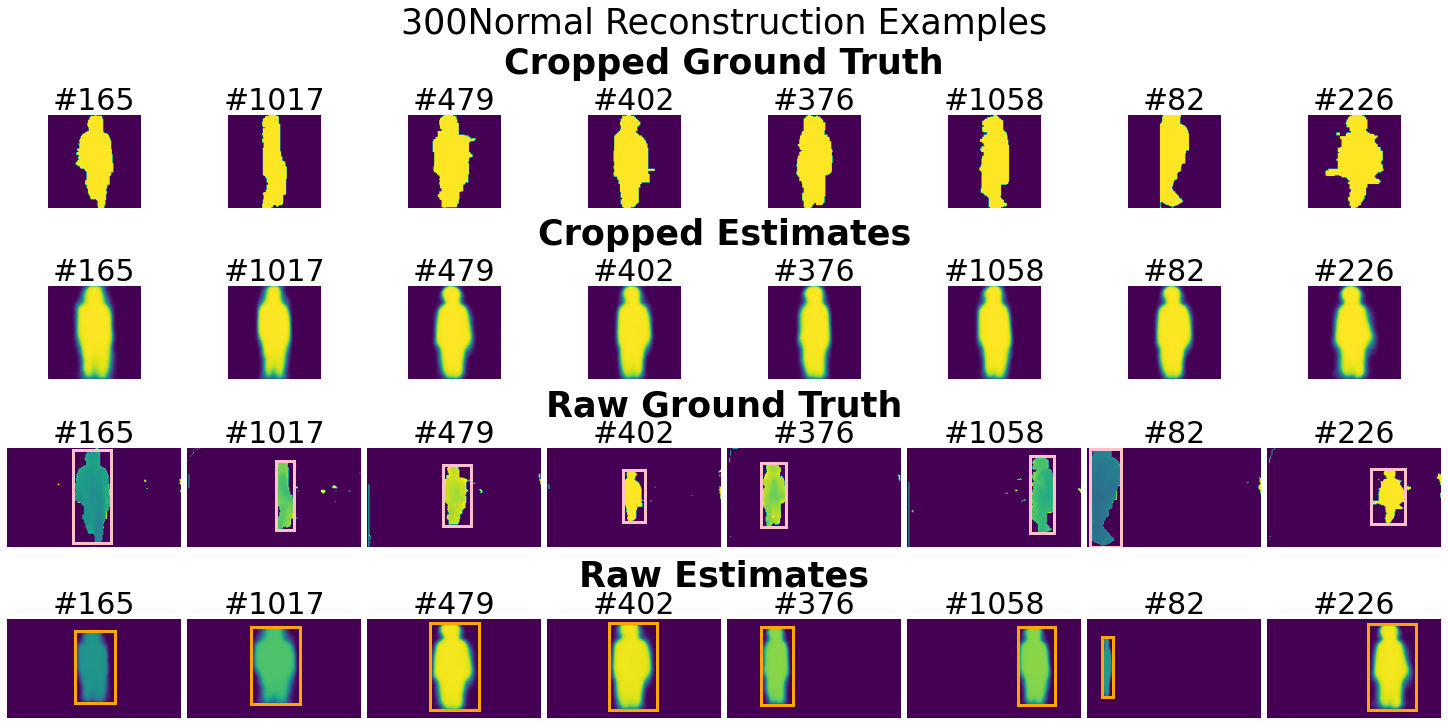

In [5]:
N300_gt = np.squeeze(np.load('../dataset/0509/make16_300-split/r_img_test.npy', mmap_mode='r'))
N300_gt_ind = np.load('../dataset/0509/make16_300-split/ind_test.npy', mmap_mode='r')

N300 = Comparison.PropResultCalculator('300Normal', '../saved/240415_300N/240415_300N_Student_pred.npy', N300_gt, N300_gt_ind)
N300.resize()
figs.append(N300.plot_example())

300Few loading...
300Few loaded Estimates of (936, 128, 128) as float32
Reconstructing...OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

186 92 5 -65
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

180 90 8 -62
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

195 93 0 -62
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

190 93 0 -64
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

53 93 0 -65
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

185 94 3 -66
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/res

<Figure size 1440x720 with 0 Axes>

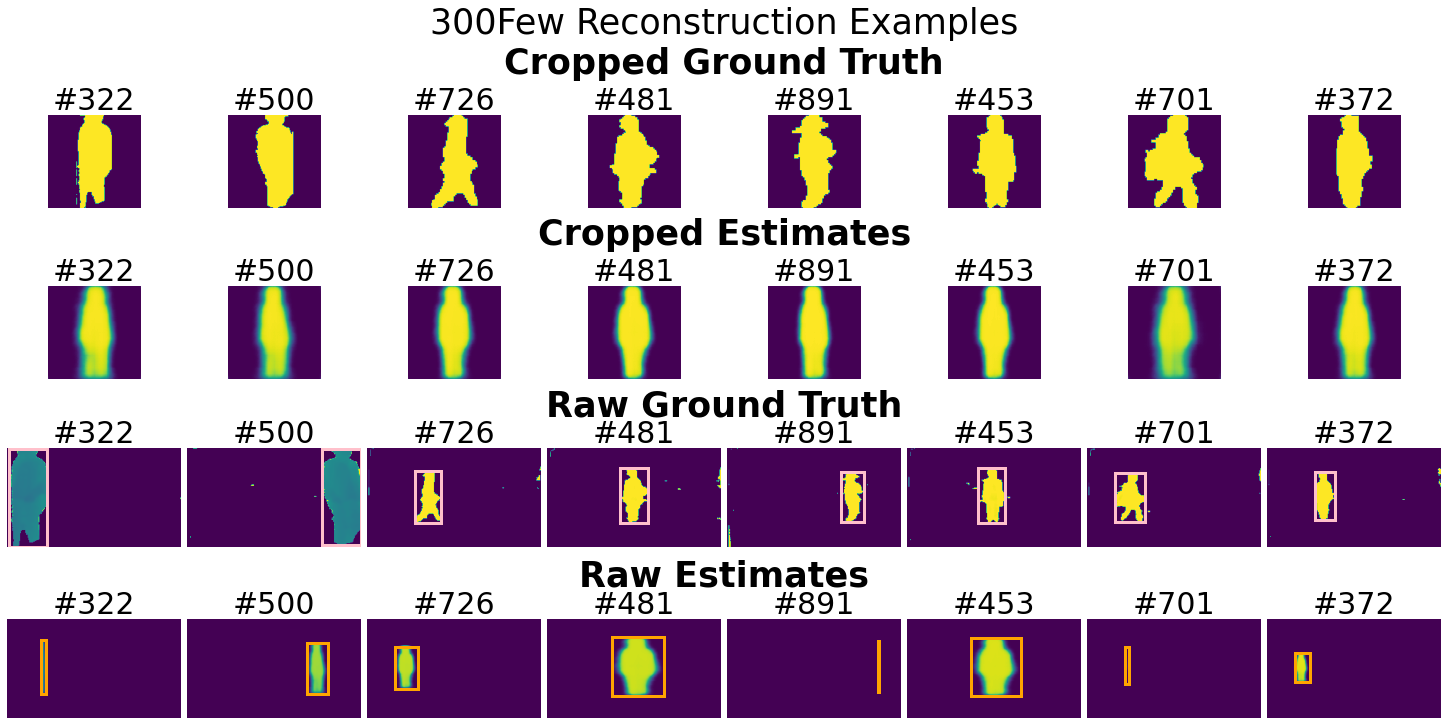

In [6]:
F300_gt = np.squeeze(np.load('../dataset/0509/make16_300-few/r_img_test.npy', mmap_mode='r'))
F300_gt_ind = np.load('../dataset/0509/make16_300-few/ind_test.npy', mmap_mode='r')

F300 = Comparison.PropResultCalculator('300Few', '../saved/240415_300F/240415_300F_Student_pred.npy', F300_gt, F300_gt_ind)
F300.resize()
figs.append(F300.plot_example())

900Normal loading...
900Normal loaded Estimates of (40, 128, 128) as float32
Reconstructing...Done
Reconstruction finished. Failure count = 0


<Figure size 1440x720 with 0 Axes>

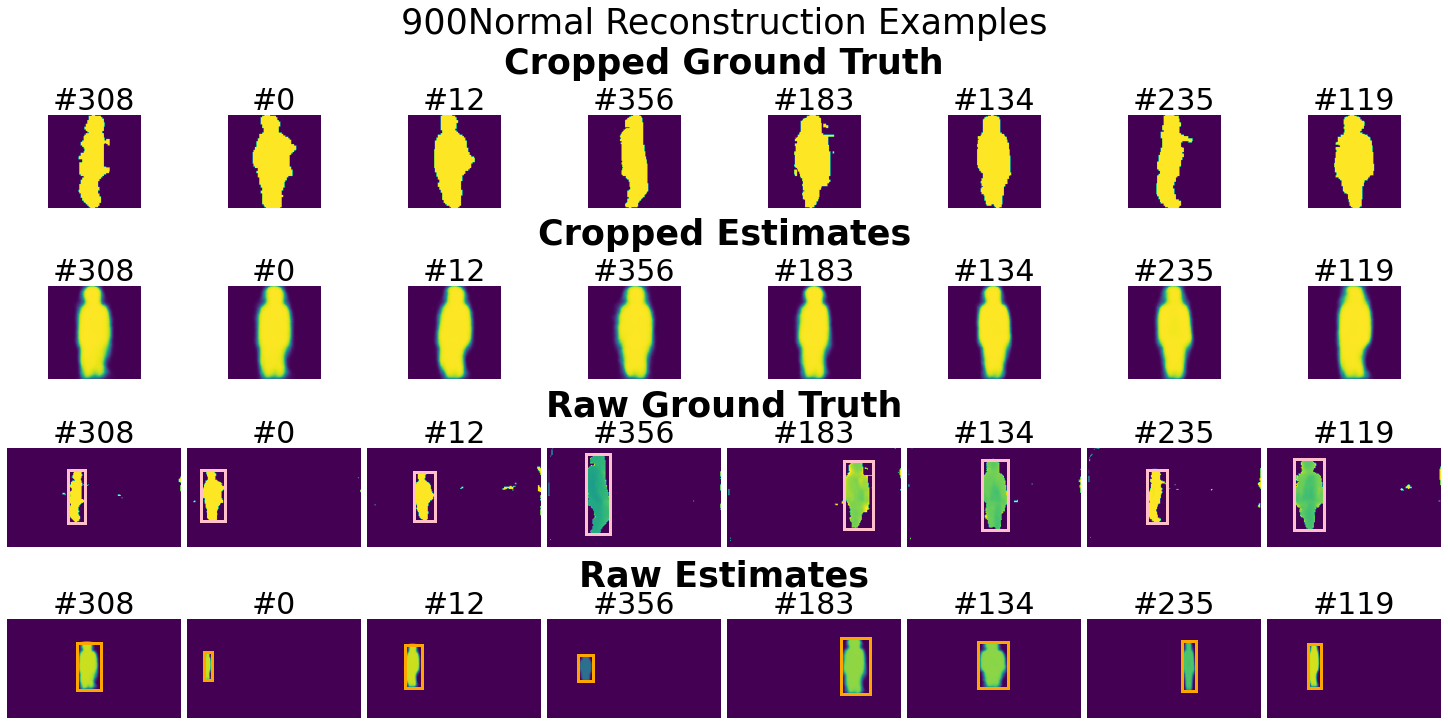

In [7]:
N900_gt = np.squeeze(np.load('../dataset/0509/make16_900-split/r_img_test.npy', mmap_mode='r'))
N900_gt_ind = np.load('../dataset/0509/make16_900-split/ind_test.npy', mmap_mode='r')

N900 = Comparison.PropResultCalculator('900Normal', '../saved/240415_900N/240415_900N_Student_pred.npy', N900_gt, N900_gt_ind)
N900.resize()
figs.append(N900.plot_example())

900Few loading...
900Few loaded Estimates of (313, 128, 128) as float32
Reconstructing...OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

204 95 1 -70
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

198 97 0 -72
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

203 97 0 -71
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

189 90 1 -61
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

202 96 0 -69
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/resize.cpp:4065: error: (-215:Assertion failed) inv_scale_x > 0 in function 'resize'

181 89 3 -55
OpenCV(4.8.1) /io/opencv/modules/imgproc/src/re

<Figure size 1440x720 with 0 Axes>

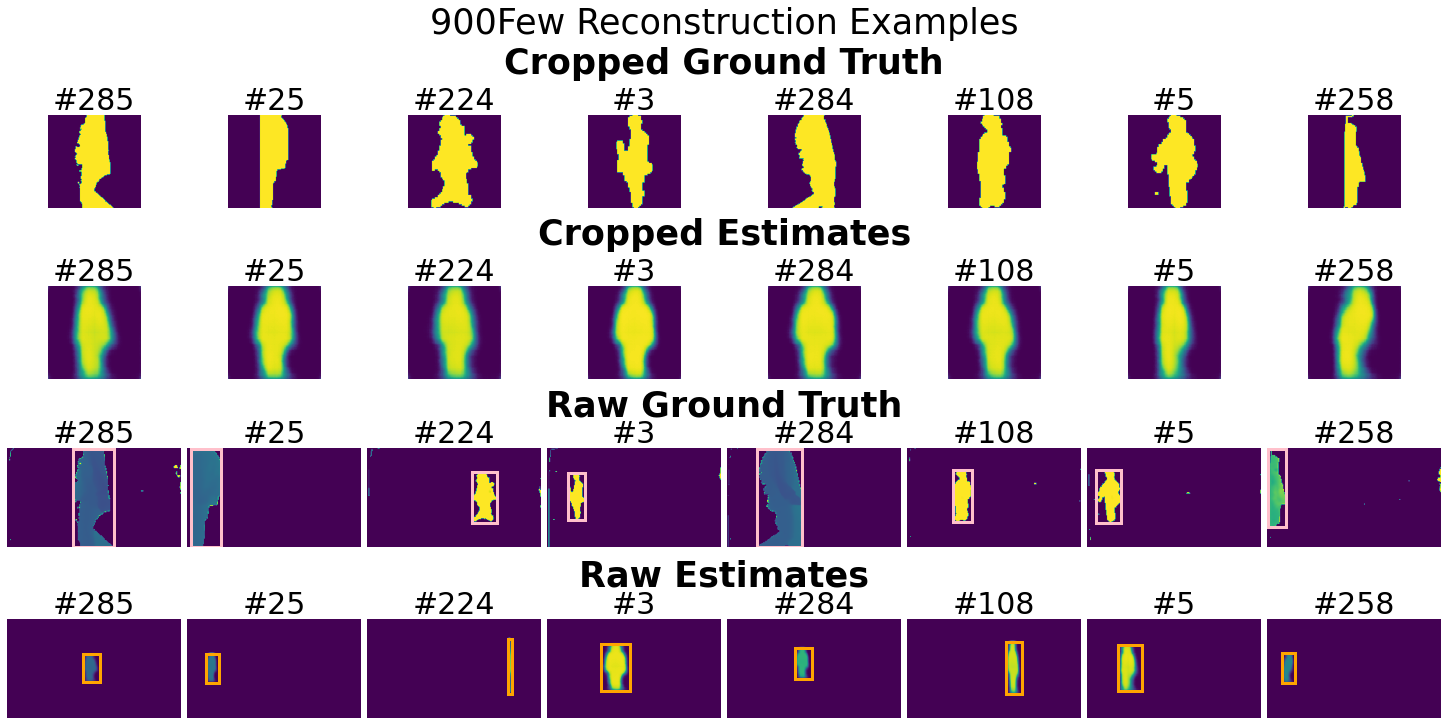

In [8]:
F900_gt = np.squeeze(np.load('../dataset/0509/make16_900-few/r_img_test.npy', mmap_mode='r'))
F900_gt_ind = np.load('../dataset/0509/make16_900-few/ind_test.npy', mmap_mode='r')

F900 = Comparison.PropResultCalculator('900Few', '../saved/240415_900F/240415_900F_Student_pred.npy', F900_gt, F900_gt_ind)
F900.resize()
figs.append(F900.plot_example())

In [11]:
Z30 = Comparison.ZeroEstimates('Z30Nromal', None, N30_gt, N30_gt_ind)

Z30Nromal loading...
Z30Nromal loaded Zero Estimates


30Nromal calculating loss...

/home/bob/datastore/Models/Comparison.py:44: UserWarning: Using a target size (torch.Size([1, 128, 226])) that is different to the input size (torch.Size([128, 226])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.result[i] = F.mse_loss(pred, torch.from_numpy(self.gt[_ind]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
30Nromal calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

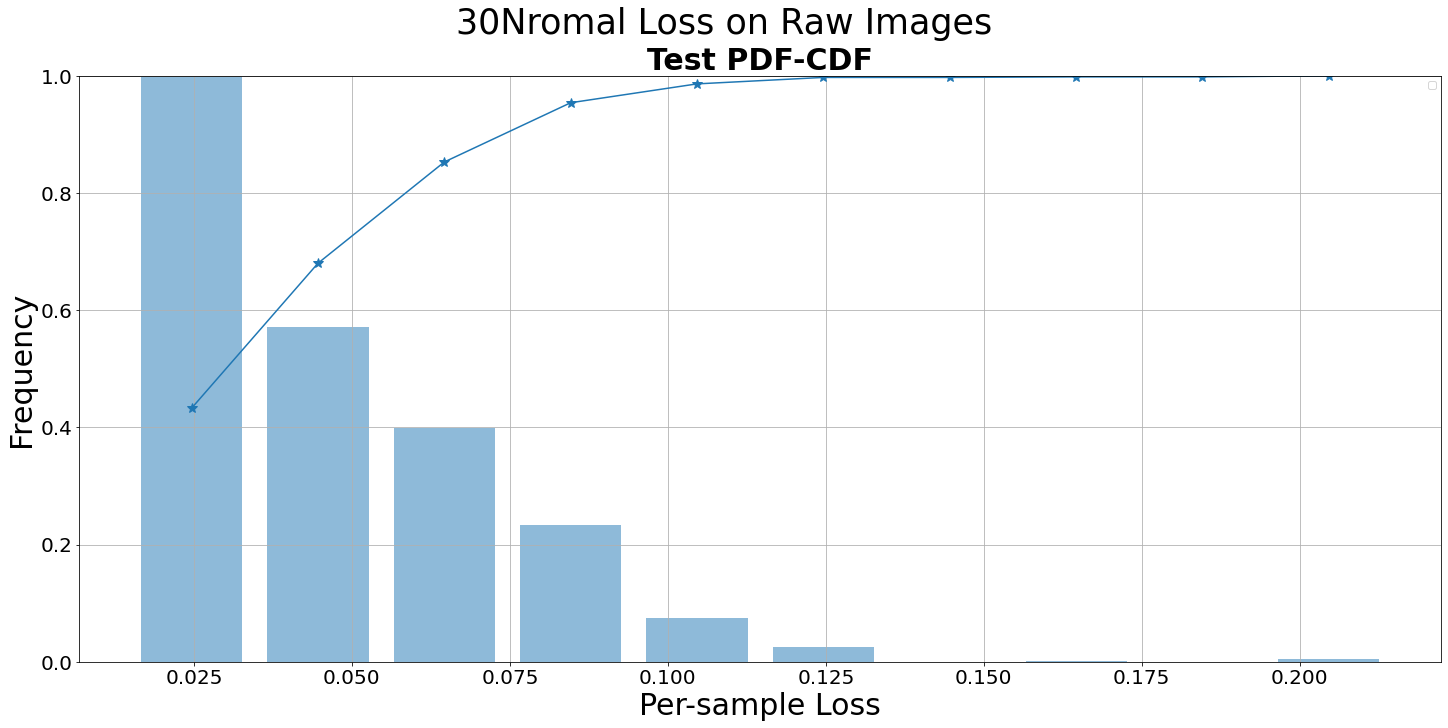

Z30Nromal calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
Z30Nromal calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

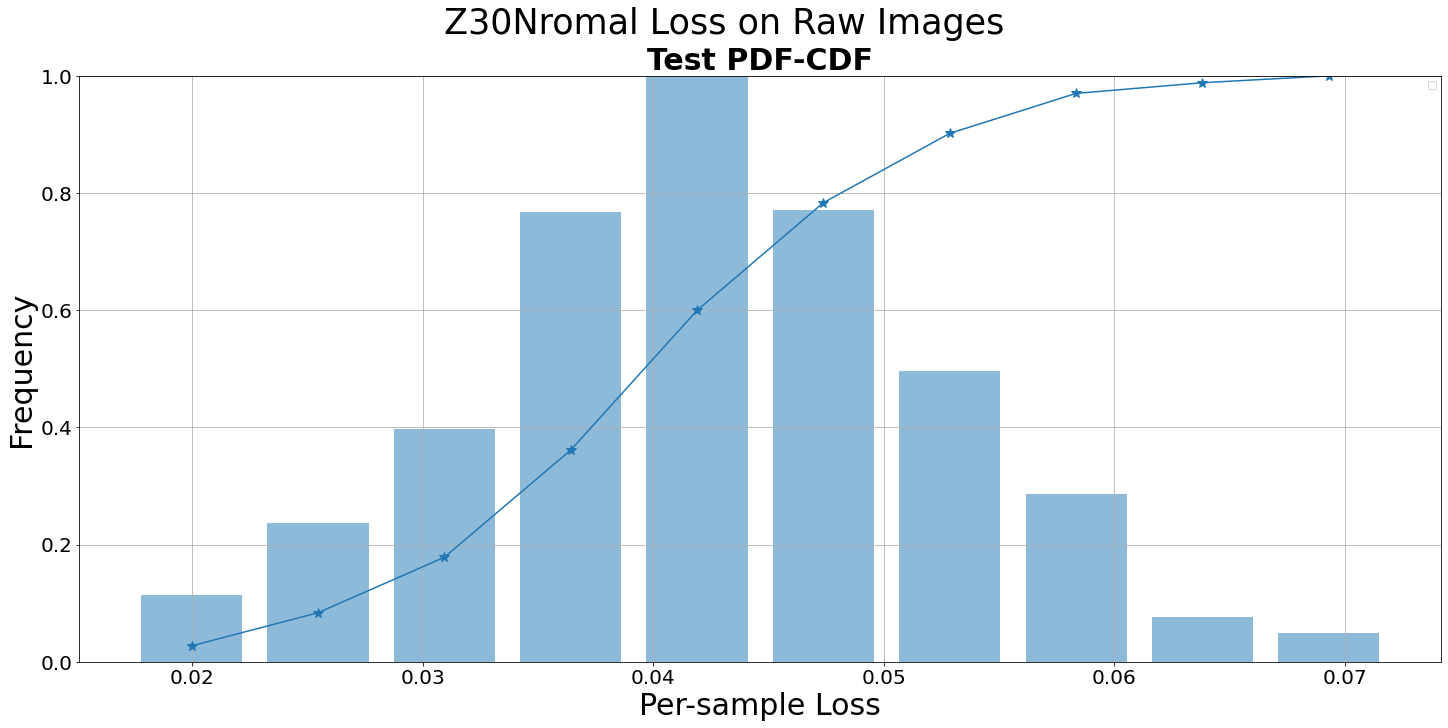

30Few calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
30Few calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

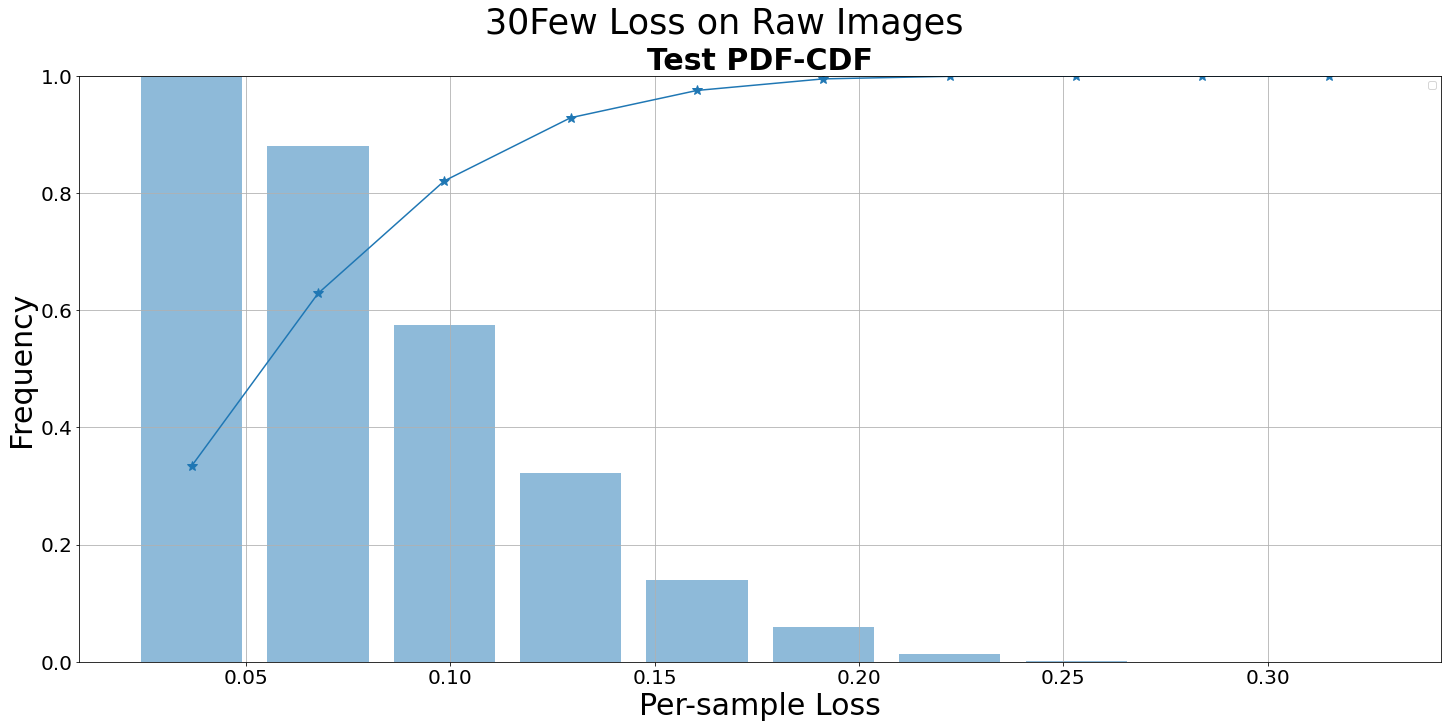

100Normal calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
100Normal calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

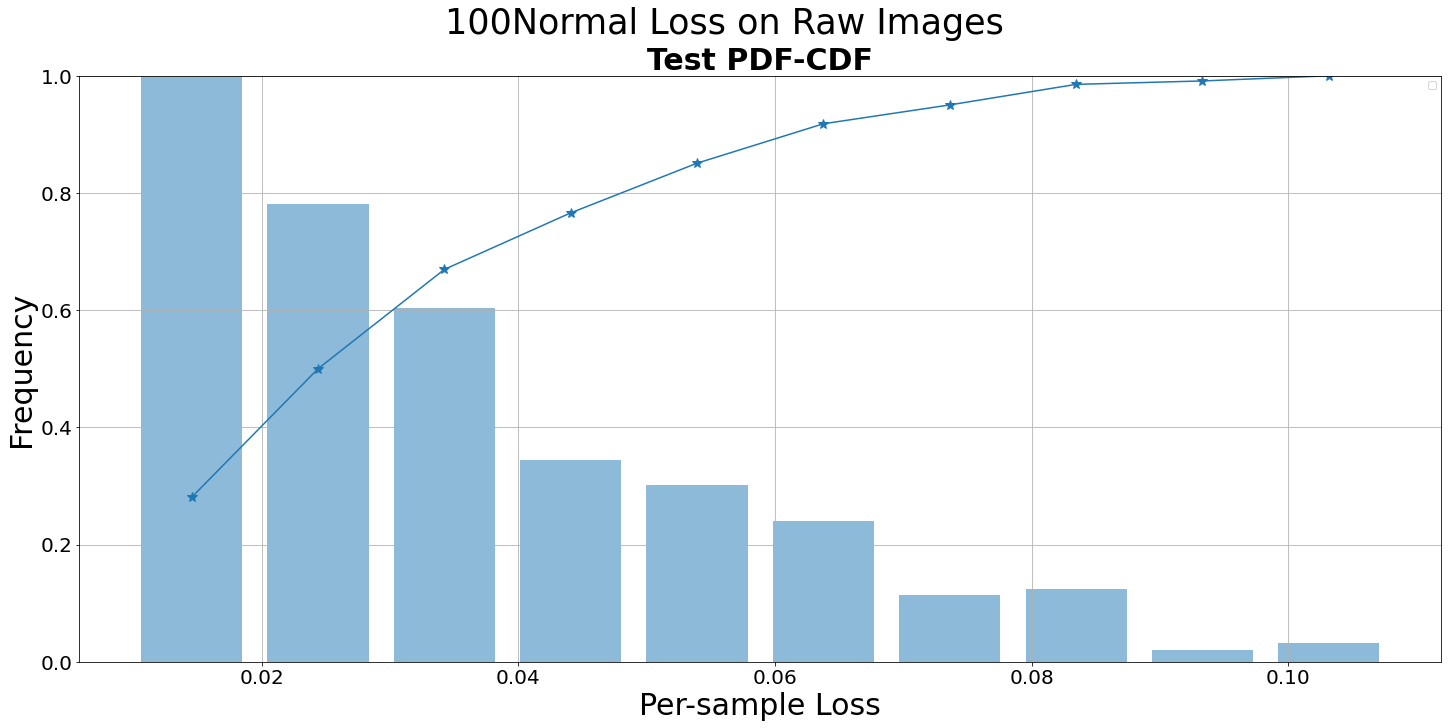

100Few calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
100Few calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

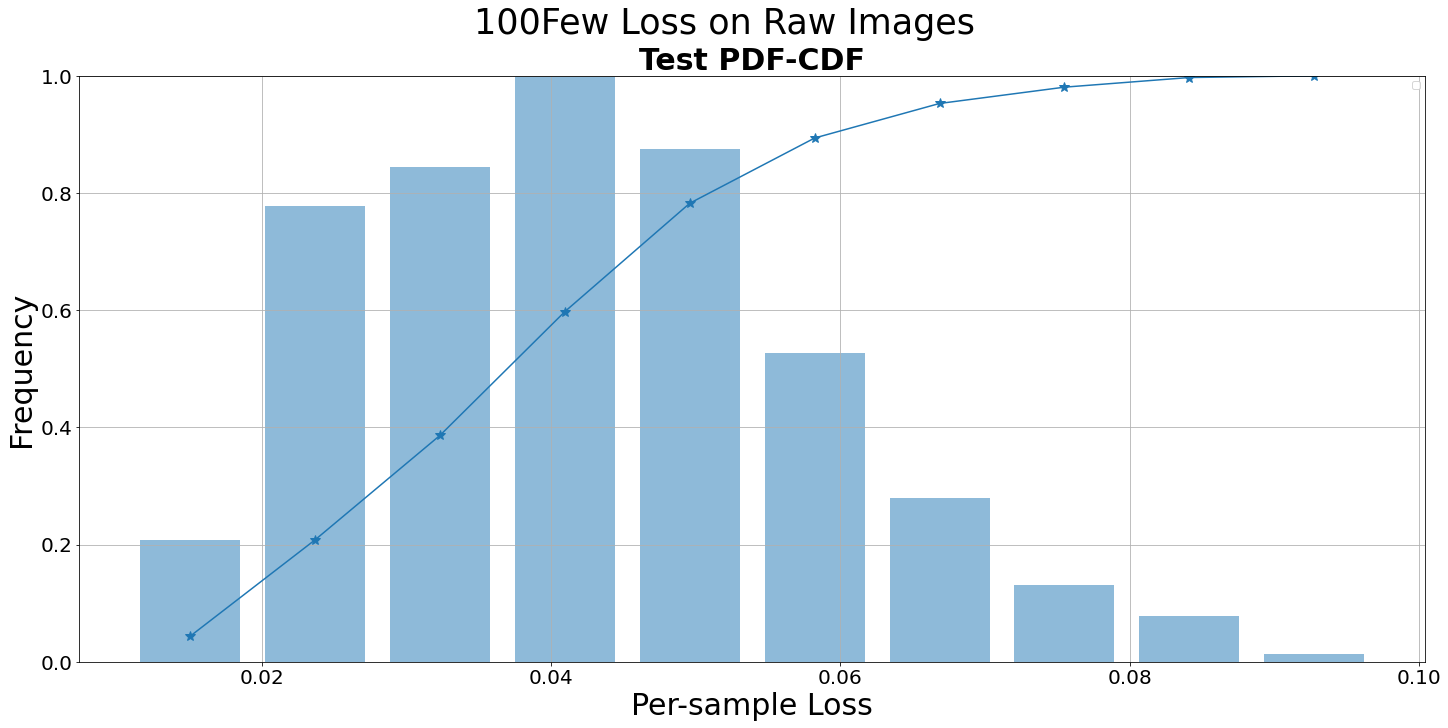

300Normal calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
300Normal calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

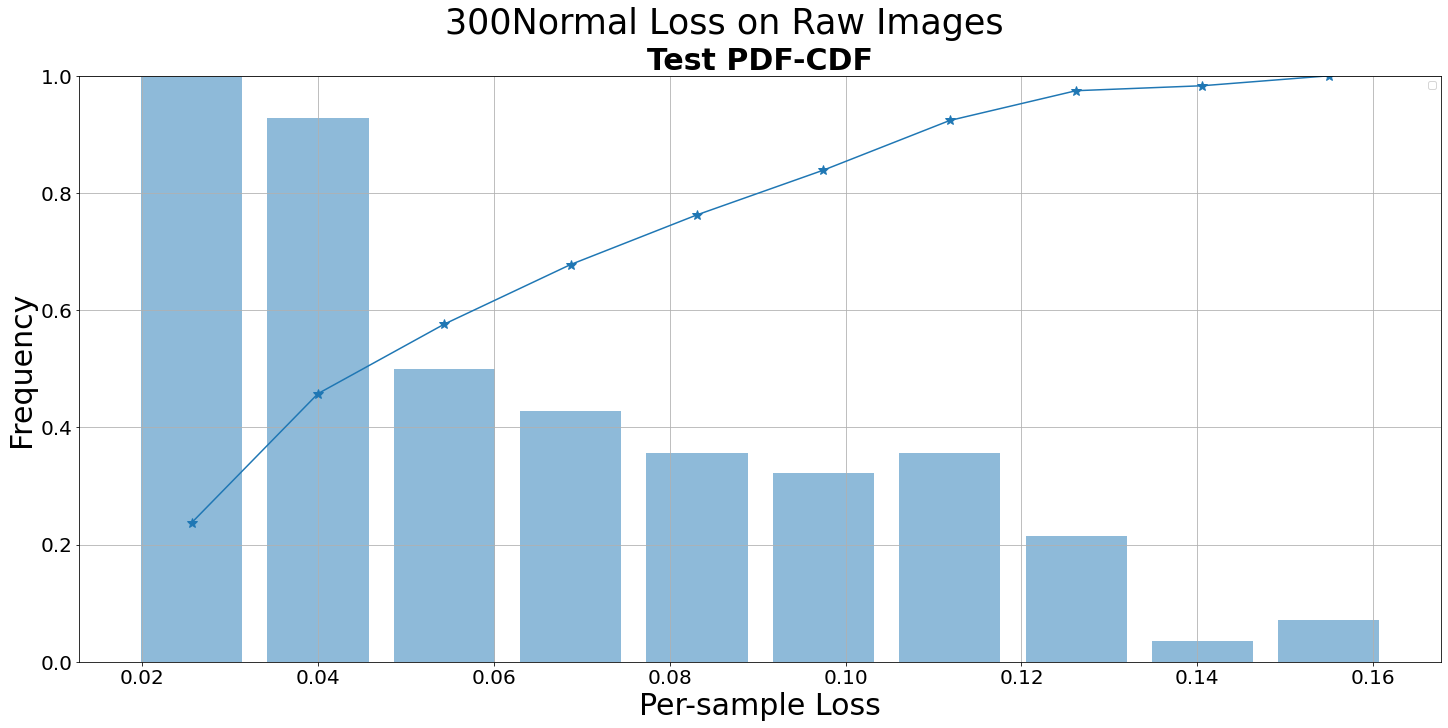

300Few calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
300Few calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

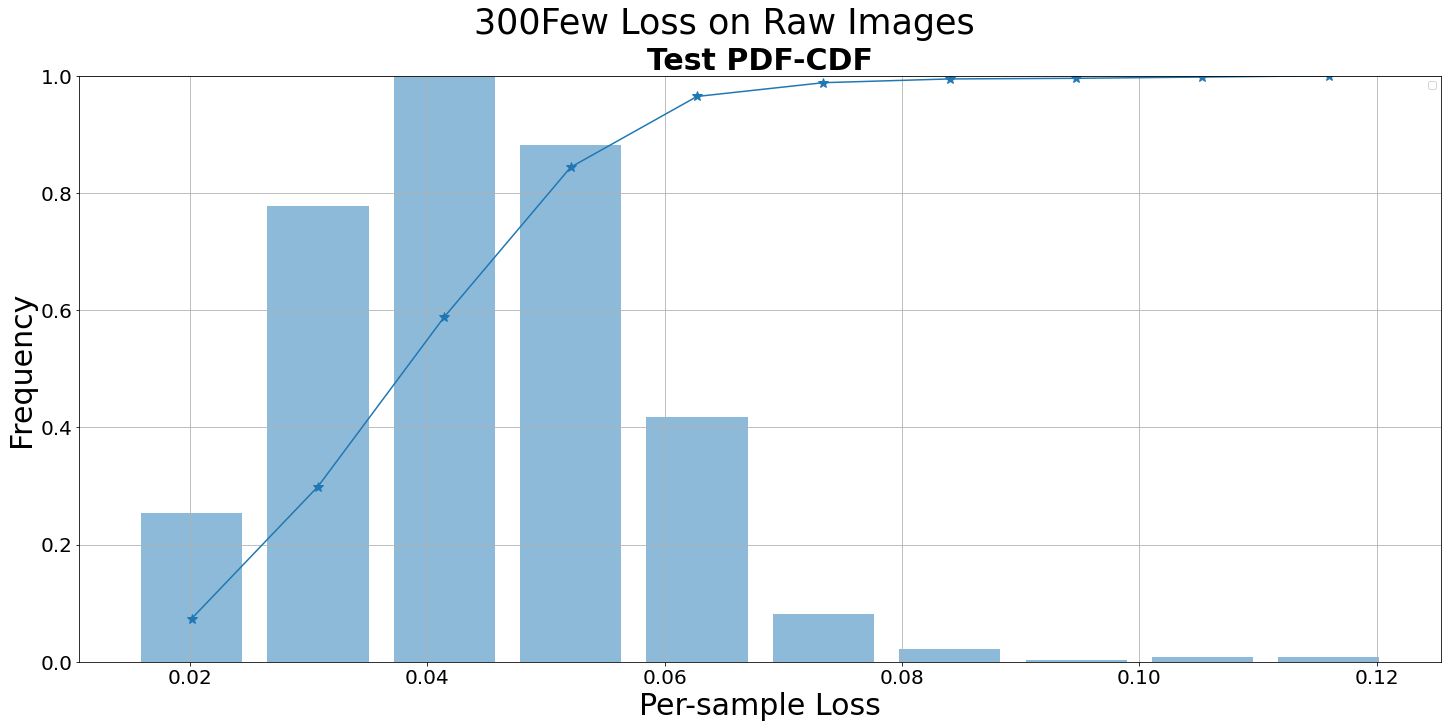

900Normal calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
900Normal calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

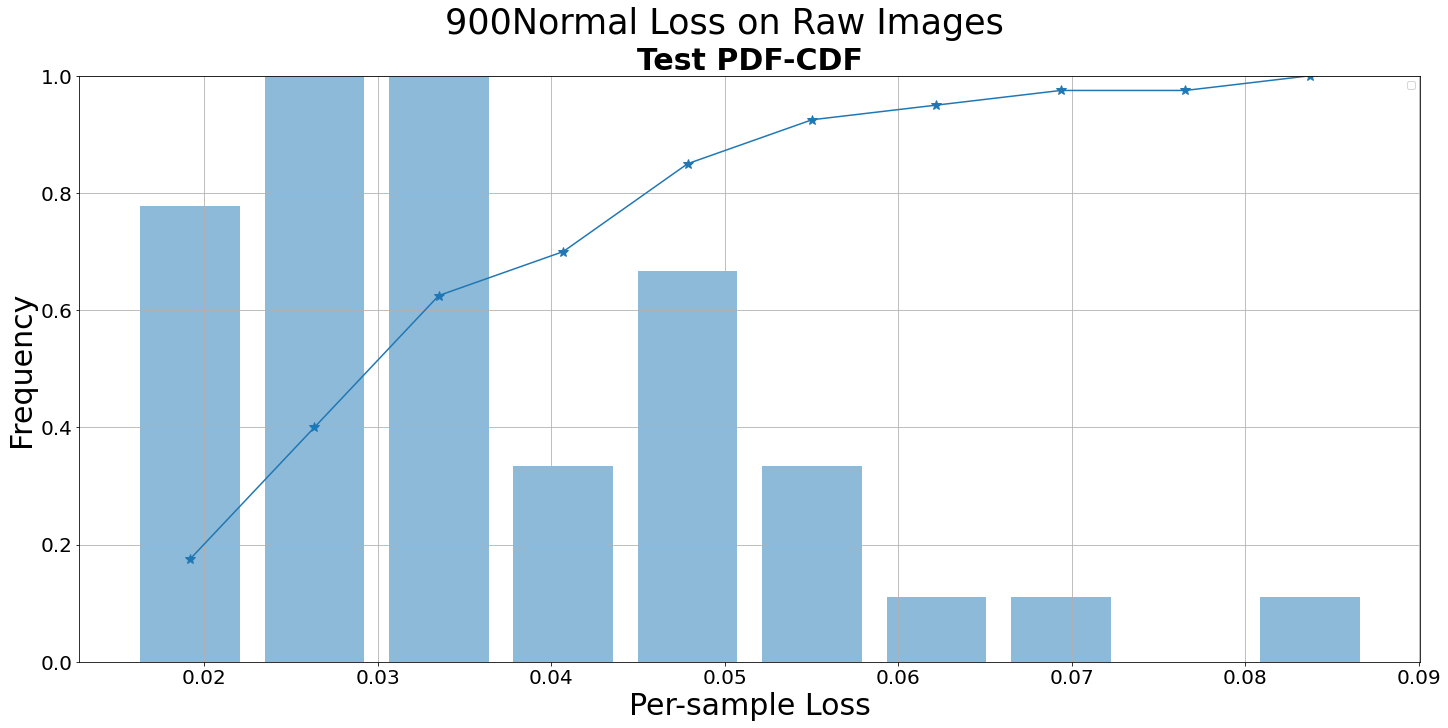

900Few calculating loss...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Done
900Few calculating histograms...Done!


<Figure size 1440x720 with 0 Axes>

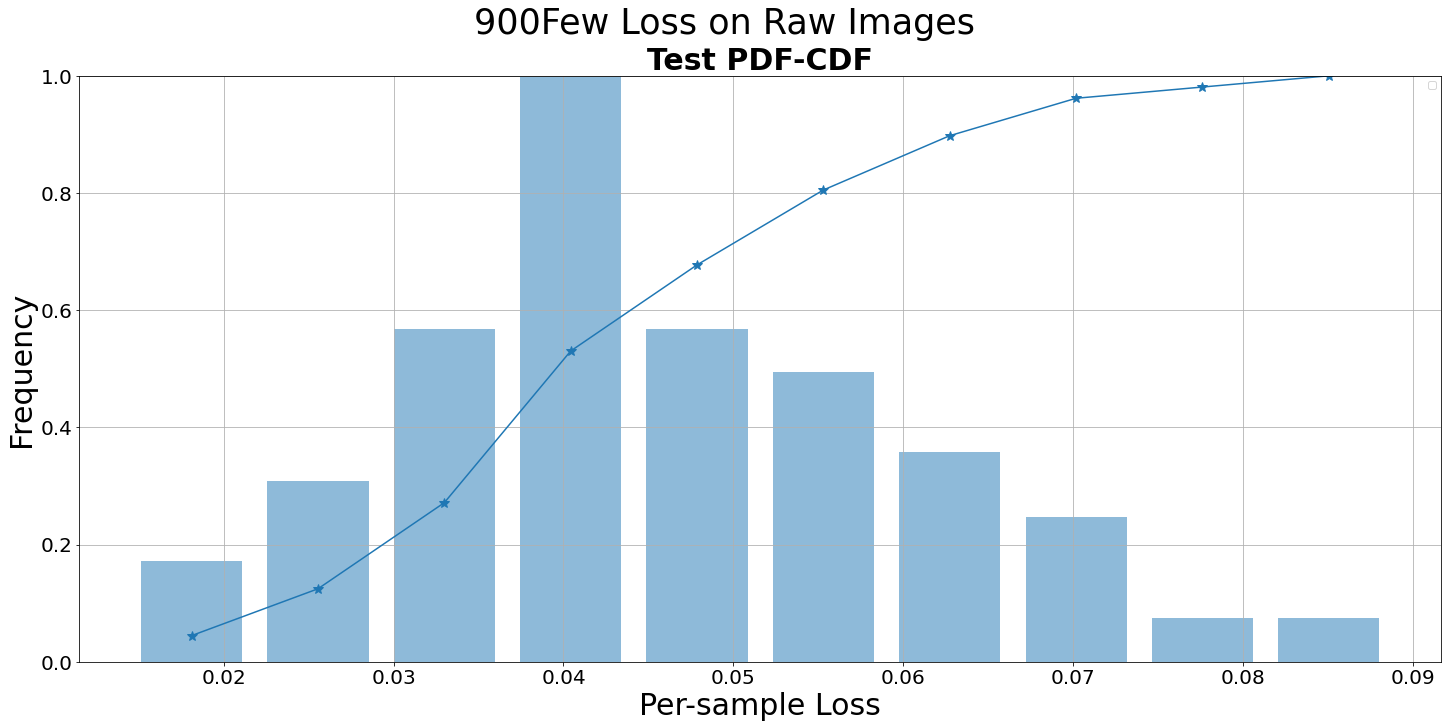

In [12]:
for method in(N30, Z30, F30, N100, F100, N300, F300, N900, F900):
    method.calculate_loss()
    fig, filename = method.calculate_cdf()

<Figure size 1440x720 with 0 Axes>

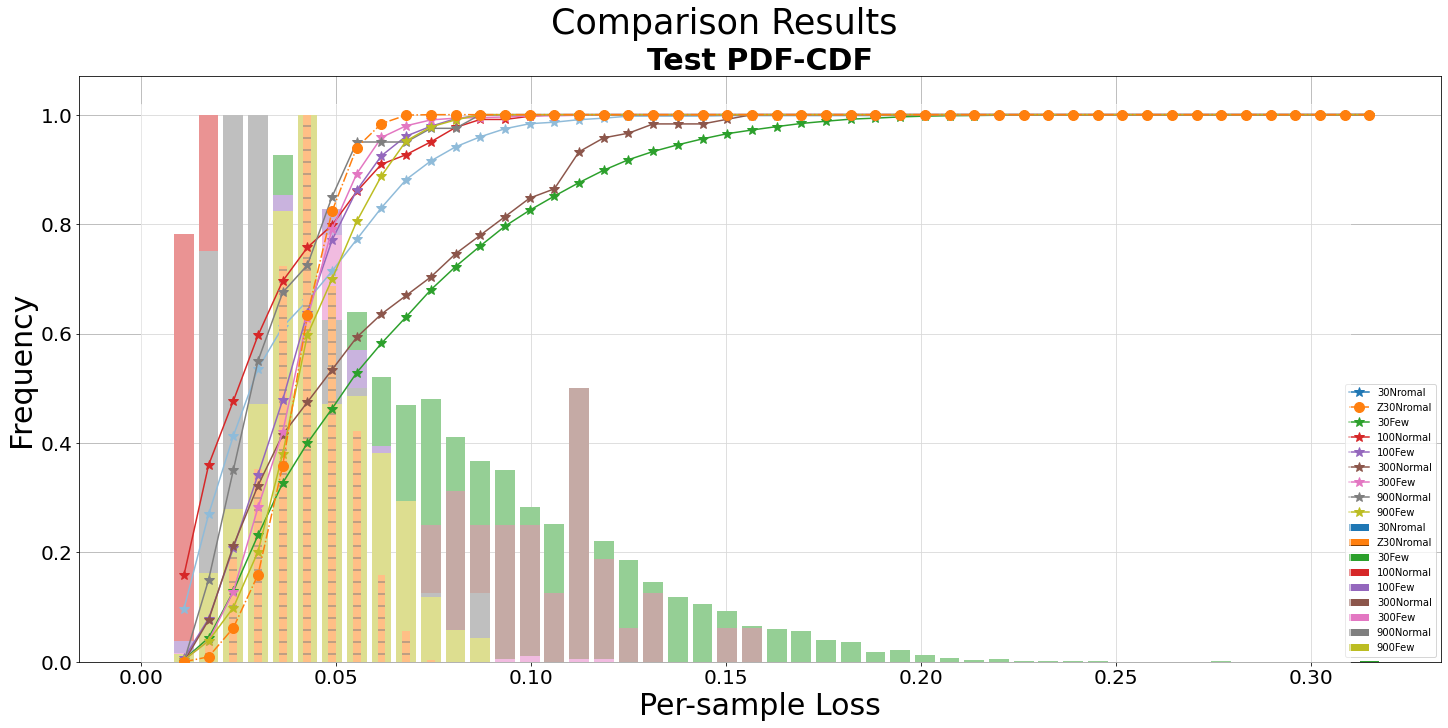

In [13]:
figs.append(Comparison.gather_plot(N30, Z30, F30, N100, F100, N300, F300, N900, F900))

In [14]:
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)
for fig, filename in figs:
    fig.savefig(f"{save_path}{notion}_{filename}")